# Pre-Trained CXR-ML-GZSL Extension Results

## Overview

This notebook uses pre-trained weights to reproduce an [extension](https://github.com/EricSchrock/cxr-ml-gzsl/blob/main/cxr_ml_gzsl_extension.ipynb) of the findings of the paper, ["Multi-Label Generalized Zero Shot Learning for the Classification of Disease in Chest Radiographs"](https://arxiv.org/abs/2107.06563).

**Note**: The dataset is large. Expect significant download times.

**Note**: If you get an error when loading the pretrained weights, it's possible they got corrupted during the download. You can manually download them at the following links.

1. https://drive.google.com/file/d/1rzvBXBX8u3Yv22ACe2qGeEpMffF6uwNh/view?usp=drive_link
2. https://drive.google.com/file/d/14flyOtpZGwBDP0pPHxHkqZWtbE-8JcNP/view?usp=drive_link

In [1]:
import argparse
from datetime import datetime, timedelta
import glob
import multiprocessing
import os
import requests
from statistics import mean
import tarfile
import time
import urllib.request

from google.colab import drive

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pandas.plotting import table
from PIL import Image
from sklearn.metrics import roc_auc_score
import torch
import torch.backends.cudnn as cudnn
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import models
import torchvision.transforms as transforms
from tqdm import tqdm

In [2]:
seed = 1002
torch.manual_seed(seed)
np.random.seed(seed)

## Environment

In [3]:
!if command -v nvidia-smi &> /dev/null; then nvidia-smi --query-gpu=name --format=csv,noheader; else echo 'No NVIDIA GPU detected'; fi
!echo
!python --version
!echo
!pip list | grep -E "matplotlib|numpy|pandas|pillow|scikit-learn|tqdm|torch|torchvision"

NVIDIA A100-SXM4-40GB

Python 3.11.12

geopandas                             1.0.1
matplotlib                            3.10.0
matplotlib-inline                     0.1.7
matplotlib-venn                       1.1.2
numpy                                 2.0.2
pandas                                2.2.2
pandas-datareader                     0.10.0
pandas-gbq                            0.28.0
pandas-stubs                          2.2.2.240909
pillow                                11.1.0
scikit-learn                          1.6.1
sklearn-pandas                        2.2.0
torch                                 2.6.0+cu124
torchaudio                            2.6.0+cu124
torchsummary                          1.5.1
torchvision                           0.21.0+cu124
tqdm                                  4.67.1


## Download

In [4]:
weights = [
    {"filename": "best_auroc_checkpoint_densenet121.pth.tar", "url": "https://drive.google.com/uc?export=download&id=1rzvBXBX8u3Yv22ACe2qGeEpMffF6uwNh"},
    {"filename": "best_auroc_checkpoint_efficientnet_b0.pth.tar", "url": "https://drive.google.com/uc?export=download&id=14flyOtpZGwBDP0pPHxHkqZWtbE-8JcNP"},
]

for item in weights:
    response = requests.get(item['url'])

    with open(item['filename'], 'wb') as f:
        f.write(response.content)

    print(f"Downloaded: {item['filename']}")

Downloaded: best_auroc_checkpoint_densenet121.pth.tar
Downloaded: best_auroc_checkpoint_efficientnet_b0.pth.tar


In [5]:
for filename in ["train.txt", "val.txt", "test.txt"]:
    response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/dataset_splits/{filename}")

    with open(filename, "w") as f:
        f.write(response.text)

    print(f"Downloaded: {filename}")

Downloaded: train.txt
Downloaded: val.txt
Downloaded: test.txt


In [6]:
filename = "Data_Entry_2017_v2020.csv"
response = requests.get('https://drive.google.com/uc?export=download&id=1mkOZNfYt-Px52b8CJZJANNbM3ULUVO3f')

with open(filename, "wb") as file:
    file.write(response.content)

print(f"Downloaded: {filename}")

Downloaded: Data_Entry_2017_v2020.csv


In [7]:
CLASS_EMBEDDINGS = "nih_chest_xray_biobert.npy"

response = requests.get(f"https://raw.githubusercontent.com/nyuad-cai/CXR-ML-GZSL/master/embeddings/{CLASS_EMBEDDINGS}")

with open(CLASS_EMBEDDINGS, "wb") as f:
    f.write(response.content)

print(f"Downloaded: {CLASS_EMBEDDINGS}")

Downloaded: nih_chest_xray_biobert.npy


In [8]:
dataset = [
    {"filename": "images_001.tar.gz", "url": "https://nihcc.box.com/shared/static/vfk49d74nhbxq3nqjg0900w5nvkorp5c.gz"},
    {"filename": "images_002.tar.gz", "url": "https://nihcc.box.com/shared/static/i28rlmbvmfjbl8p2n3ril0pptcmcu9d1.gz"},
    {"filename": "images_003.tar.gz", "url": "https://nihcc.box.com/shared/static/f1t00wrtdk94satdfb9olcolqx20z2jp.gz"},
    {"filename": "images_004.tar.gz", "url": "https://nihcc.box.com/shared/static/0aowwzs5lhjrceb3qp67ahp0rd1l1etg.gz"},
    {"filename": "images_005.tar.gz", "url": "https://nihcc.box.com/shared/static/v5e3goj22zr6h8tzualxfsqlqaygfbsn.gz"},
    {"filename": "images_006.tar.gz", "url": "https://nihcc.box.com/shared/static/asi7ikud9jwnkrnkj99jnpfkjdes7l6l.gz"},
]

for item in dataset:
    filename = item["filename"]
    url = item["url"]

    urllib.request.urlretrieve(url, filename)

    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()

    os.remove(filename)

    print(f"Downloaded and extracted: {filename}")

IMAGE_PATH = "images"

assert os.path.exists(IMAGE_PATH), "Dataset is not in the expected directory!"

Downloaded and extracted: images_001.tar.gz
Downloaded and extracted: images_002.tar.gz
Downloaded and extracted: images_003.tar.gz
Downloaded and extracted: images_004.tar.gz
Downloaded and extracted: images_005.tar.gz
Downloaded and extracted: images_006.tar.gz


## Dataset

In [9]:
class NIHChestXray(Dataset):
    def __init__ (self, args, pathDatasetFile, transform, classes_to_load='seen', exclude_all=True):
        self.listImagePaths = []
        self.listImageLabels = []
        self.transform = transform
        self.num_classes = args.num_classes

        self._data_path = args.data_root
        self.args = args

        self.split_path = pathDatasetFile
        self.CLASSES = [ 'Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia',
                'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']

        self.unseen_classes = ['Edema', 'Pneumonia', 'Emphysema', 'Fibrosis']

        self.seen_classes = [ 'Atelectasis', 'Effusion', 'Infiltration', 'Mass', 'Nodule',
                'Pneumothorax', 'Consolidation', 'Cardiomegaly', 'Pleural_Thickening', 'Hernia']

        self._class_ids = {v: i for i, v in enumerate(self.CLASSES) if v != 'No Finding'}

        self.seen_class_ids = [self._class_ids[label] for label in self.seen_classes]
        self.unseen_class_ids = [self._class_ids[label] for label in self.unseen_classes]

        self.classes_to_load = classes_to_load
        self.exclude_all = exclude_all
        self._construct_index()

    def _construct_index(self):
        # Compile the split data path
        max_labels = 0
        paths = glob.glob('images/*.png' if self._data_path == '' else f'{self._data_path}/images/*.png')
        self.names_to_path = {path.split('/')[-1]: path for path in paths}
        data_entry_file = 'Data_Entry_2017_v2020.csv'

        print(f'data partition path: {self.split_path}')
        with open(self.split_path, 'r') as f: file_names = f.readlines()

        split_file_names = np.array([file_name.strip().split(' ')[0].split('/')[-1] for file_name in file_names])
        df = pd.read_csv(f'{data_entry_file}' if self._data_path == '' else f'{self._data_path}/{data_entry_file}')
        image_index = df.iloc[:, 0].values

        _, split_index, _ = np.intersect1d(image_index, split_file_names, return_indices=True)

        labels = df.iloc[:, 1].values
        labels = np.array(labels)[split_index]

        labels = [label.split('|') for label in labels]

        image_index = image_index[split_index]

        # Construct the image db
        self._imdb = []
        self.class_ids_loaded = []
        for index in range(len(split_index)):
            if len(labels[index]) == 1 and labels[index][0] == 'No Finding':
                continue
            if self._should_load_image(labels[index]) is False:
                continue
            if image_index[index] not in self.names_to_path.keys():
                continue
            class_ids = [self._class_ids[label] for label in labels[index]]
            self.class_ids_loaded +=class_ids
            self._imdb.append({
                'im_path': self.names_to_path[image_index[index]],
                'labels': class_ids,
            })
            max_labels = max(max_labels, len(class_ids))

        self.class_ids_loaded = np.unique(np.array(self.class_ids_loaded))
        print(f'Number of images: {len(self._imdb)}')
        print(f'Number of max labels per image: {max_labels}')
        print(f'Number of classes: {len(self.class_ids_loaded)}')

    def _should_load_image(self, labels):
        selected_class_labels = self.CLASSES
        if self.classes_to_load == 'seen':
            selected_class_labels = self.seen_classes
        elif self.classes_to_load == 'unseen':
            selected_class_labels = self.unseen_classes
        elif self.classes_to_load == 'all':
            return True

        count = 0
        for label in labels:
            if label in selected_class_labels:
                count+=1

        if count == len(labels):
            # all labels from selected sub set
            return True
        elif count == 0:
            # none label in selected sub set
            return False
        else:
            # some labels in selected sub set
            if self.exclude_all is True:
                return False
            else:
                return True

    def __getitem__(self, index):
        imagePath = self._imdb[index]['im_path']
        imageData = Image.open(imagePath).convert('RGB')
        labels = torch.tensor(self._imdb[index]['labels'])
        labels = labels.unsqueeze(0)
        imageLabel = torch.zeros(labels.size(0), self.num_classes).scatter_(1, labels, 1.).squeeze()
        img = self.transform(imageData)

        return img, imageLabel

    def __len__(self):
        return len(self._imdb)

## Model

In [10]:
class RankingLoss(nn.Module):
    def __init__(self, neg_penalty=0.03):
        super(RankingLoss, self).__init__()

        self.neg_penalty = neg_penalty

    def forward(self, ranks, labels, class_ids_loaded, device):
        '''
        for each correct it should be higher then the absence
        '''
        labels = labels[:, class_ids_loaded]
        ranks_loaded = ranks[:, class_ids_loaded]
        neg_labels = 1+(labels*-1)
        loss_rank = torch.zeros(1).to(device)
        for i in range(len(labels)):
            correct = ranks_loaded[i, labels[i]==1]
            wrong = ranks_loaded[i, neg_labels[i]==1]
            correct = correct.reshape((-1, 1)).repeat((1, len(wrong)))
            wrong = wrong.repeat(len(correct)).reshape(len(correct), -1)
            image_level_penalty = ((self.neg_penalty+wrong) - correct)
            image_level_penalty[image_level_penalty<0]=0
            loss_rank += image_level_penalty.sum()
        loss_rank /=len(labels)

        return loss_rank

class CosineLoss(nn.Module):
    def forward(self, t_emb, v_emb ):
        a_norm = v_emb / v_emb.norm(dim=1)[:, None]
        b_norm = t_emb / t_emb.norm(dim=1)[:, None]
        loss = 1 - torch.mean(torch.diagonal(torch.mm(a_norm, b_norm.t()), 0))

        return loss

class ZSLNet(nn.Module):
    def __init__(self, args, textual_embeddings=None, device='cpu'):
        super(ZSLNet, self).__init__()
        self.args = args
        self.device = device
        self.vision_backbone = getattr(torchvision.models, self.args.vision_backbone)(pretrained=self.args.pretrained)
        # remove classification layer from visual encoder
        classifiers = [ 'classifier', 'fc']
        for classifier in classifiers:
            cls_layer = getattr(self.vision_backbone, classifier, None)
            if cls_layer is None:
                continue
            if isinstance(cls_layer, nn.Sequential):
                last_layer = cls_layer[-1]
                d_visual = last_layer.in_features
            else:
                d_visual = cls_layer.in_features
            setattr(self.vision_backbone, classifier, nn.Identity(d_visual))
            break

        pretrained_encoder = False
        if pretrained_encoder:
            self.vision_backbone.classifier = nn.Identity(d_visual)

            path = 'checkpoints/bce_only_imagenet/last_epoch_checkpoint.pth.tar'

            self.classifier = nn.Sequential(nn.Linear(d_visual, self.args.num_classes), nn.Sigmoid())
            checkpoint = torch.load(path, weights_only=False)
            self.load_state_dict(checkpoint['state_dict'])

            for p in self.vision_backbone.parameters():
                p.requires_grad = False

        if self.args.bce_only:
            self.bce_loss = torch.nn.BCELoss(size_average=True)
            self.classifier = nn.Sequential(nn.Linear(d_visual, self.args.num_classes), nn.Sigmoid())
        else:
            self.emb_loss = CosineLoss()
            self.ranking_loss = RankingLoss(neg_penalty=self.args.neg_penalty)
            self.textual_embeddings = textual_embeddings
            d_textual = self.textual_embeddings.shape[-1]

            self.textual_embeddings = torch.from_numpy(self.textual_embeddings).to(self.device)

            self.fc_v = nn.Sequential(
                nn.Linear(d_visual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128),
            )

            self.fc_t = nn.Sequential(
                nn.Linear(d_textual, 512),
                nn.ReLU(),
                nn.Linear(512, 256),
                nn.ReLU(),
                nn.Linear(256, 128)
            )

    def forward(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        if self.args.bce_only:
            return self.forward_bce_only(x, labels=labels, n_crops=n_crops, bs=bs)
        else:
            return self.forward_ranking(x, labels=labels, epoch=epoch, n_crops=n_crops, bs=bs)

    def forward_bce_only(self, x, labels=None, n_crops=0, bs=16):
        lossvalue_bce = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        preds = self.classifier(visual_feats)

        if labels is not None:
            lossvalue_bce = self.bce_loss(preds, labels)

        return preds, lossvalue_bce, f'bce:\t {lossvalue_bce.item():0.4f}'

    def forward_ranking(self, x, labels=None, epoch=0, n_crops=0, bs=16):
        loss_rank = torch.zeros(1).to(self.device)
        loss_allignment_cos = torch.zeros(1).to(self.device)
        loss_mapping_consistency = torch.zeros(1).to(self.device)

        visual_feats = self.vision_backbone(x)
        visual_feats = self.fc_v(visual_feats)
        text_feats = self.fc_t(self.textual_embeddings)

        if not self.args.wo_con and epoch >= 0:
            text_mapped_sim = self.sim_score(text_feats, text_feats.detach())
            text_orig_sim = self.sim_score(self.textual_embeddings, self.textual_embeddings)
            loss_mapping_consistency = torch.abs(text_orig_sim - text_mapped_sim).mean()

        if labels is not None:
            mapped_visual, mapped_text = self.map_visual_text(visual_feats, labels, text_feats)
            if mapped_visual is not None and not self.args.wo_map and epoch >= 0:
                loss_allignment_cos = self.emb_loss(mapped_text, mapped_visual)

        ranks = self.sim_score(visual_feats, text_feats)
        if n_crops > 0:
            ranks = ranks.view(bs, n_crops, -1).mean(1)

        if labels is not None:
            loss_rank = self.ranking_loss(ranks, labels, self.class_ids_loaded, self.device)
        loss_allignment_cos = (self.args.beta_map * loss_allignment_cos)
        loss_rank = (self.args.beta_rank * loss_rank)
        loss_mapping_consistency = (self.args.beta_con * loss_mapping_consistency)
        losses = loss_rank + loss_mapping_consistency + loss_allignment_cos

        return ranks, losses

    def sim_score(self, a, b):
        a_norm = a / a.norm(dim=1)[:, None]
        b_norm = b / (1e-6+b.norm(dim=1))[:, None]
        score = (torch.mm(a_norm, b_norm.t()))

        return score

    def map_visual_text(self, visual_feats, labels, labels_embd):
        mapped_labels_embd = []
        labels == 1
        for i in range(0, labels.shape[0]):
            class_embd = labels_embd[labels[i]==1].mean(dim=0)[None,:]
            mapped_labels_embd.append(class_embd)
        mapped_labels_embd = torch.cat(mapped_labels_embd)

        return visual_feats.detach(), mapped_labels_embd.detach()

## Helpers

In [11]:
def plot_array(array, disc='loss'):
    plt.plot(array)
    plt.ylabel(disc)
    plt.savefig(f'{disc}.pdf')
    plt.close()

class ChexnetTrainer(object):
    def __init__(self, args):
        self.args = args
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

        self.textual_embeddings = np.load(args.textual_embeddings)

        self.model = ZSLNet(self.args, self.textual_embeddings, self.device).to(self.device)
        self.optimizer = optim.Adam (self.model.parameters(), lr=self.args.lr, betas=(0.9, 0.999), eps=1e-08, weight_decay=1e-5)
        self.scheduler = ReduceLROnPlateau(self.optimizer, factor=0.01, patience=10, mode='min')

        self.loss = torch.nn.BCELoss(size_average=True)
        self.auroc_min_loss = 0.0

        self.start_epoch = 1
        self.lossMIN = float('inf')
        self.max_auroc_mean = float('-inf')
        self.best_epoch = 1

        self.val_losses = []

        self.resume_from()
        self.load_from()
        self.init_dataset()

        self.steps = [int(step) for step in self.args.steps.split(',')]
        self.time_start = time.time()
        self.time_end = time.time()
        self.should_test = False
        self.model.class_ids_loaded = self.train_dl.dataset.class_ids_loaded

    def __call__(self):
        self.train()

    def load_from(self):
        if self.args.load_from is not None:
            checkpoint = torch.load(self.args.load_from, weights_only=False)
            self.model.load_state_dict(checkpoint['state_dict'])
            print(f'loaded checkpoint from {self.args.load_from}')

    def resume_from(self):
        if self.args.resume_from is not None:
            checkpoint = torch.load(self.args.resume_from, weights_only=False)
            self.model.load_state_dict(checkpoint['state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer'])
            self.start_epoch = checkpoint['epoch'] + 1
            self.lossMIN = checkpoint['lossMIN']
            self.max_auroc_mean = checkpoint['max_auroc_mean']
            print(f'resuming training from epoch {self.start_epoch}')

    def save_checkpoint(self, prefix='best'):
        path = f'{self.args.save_dir}/{prefix}_checkpoint.pth.tar'
        torch.save(
            {
            'epoch': self.epoch,
            'state_dict': self.model.state_dict(),
            'max_auroc_mean': self.max_auroc_mean,
            'optimizer' : self.optimizer.state_dict(),
            'lossMIN' : self.lossMIN
            }, path)
        print(f"saving {prefix} checkpoint")

    def init_dataset(self):
        normalize = transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])

        train_transforms = []
        train_transforms.append(transforms.RandomResizedCrop(self.args.crop))
        train_transforms.append(transforms.RandomHorizontalFlip())
        train_transforms.append(transforms.ToTensor())
        train_transforms.append(normalize)

        datasetTrain = NIHChestXray(self.args, self.args.train_file, transform=transforms.Compose(train_transforms))

        self.train_dl = DataLoader(dataset=datasetTrain, batch_size=self.args.batch_size, shuffle=True,  num_workers=4, pin_memory=True)

        test_transforms = []
        test_transforms.append(transforms.Resize(self.args.resize))
        test_transforms.append(transforms.TenCrop(self.args.crop))
        test_transforms.append(transforms.Lambda(lambda crops: torch.stack([transforms.ToTensor()(crop) for crop in crops])))
        test_transforms.append(transforms.Lambda(lambda crops: torch.stack([normalize(crop) for crop in crops])))

        datasetVal = NIHChestXray(self.args, self.args.val_file, transform=transforms.Compose(test_transforms))
        self.val_dl = DataLoader(dataset=datasetVal, batch_size=self.args.batch_size*10, shuffle=False, num_workers=4, pin_memory=True)

        datasetTest = NIHChestXray(self.args, self.args.test_file, transform=transforms.Compose(test_transforms), classes_to_load='all')
        self.test_dl = DataLoader(dataset=datasetTest, batch_size=self.args.batch_size*3, num_workers=8, shuffle=False, pin_memory=True)
        print(datasetTest.CLASSES)

    def train(self):
        for self.epoch in range(self.start_epoch, self.args.epochs + 1):
            self.epochTrain()
            lossVal, val_ind_auroc = self.epochVal()
            val_ind_auroc = np.array(val_ind_auroc)

            aurocMean = val_ind_auroc.mean()
            self.save_checkpoint(prefix=f'last_epoch')
            self.should_test = False

            if aurocMean > self.max_auroc_mean:
                self.max_auroc_mean = aurocMean
                self.save_checkpoint(prefix='best_auroc')
                self.best_epoch = self.epoch
                self.should_test = True

            if lossVal < self.lossMIN:
                self.lossMIN = lossVal
                self.auroc_min_loss = aurocMean
                self.save_checkpoint(prefix='min_loss')
                self.should_test = True

            self.print_auroc(val_ind_auroc, self.val_dl.dataset.class_ids_loaded, prefix='val')
            if self.should_test is True:
                test_ind_auroc = self.test()
                test_ind_auroc = np.array(test_ind_auroc)

                self.write_results(val_ind_auroc, self.val_dl.dataset.class_ids_loaded, prefix=f'\n\nepoch {self.epoch}\nval', mode='a')

                self.write_results(test_ind_auroc[self.test_dl.dataset.seen_class_ids], self.test_dl.dataset.seen_class_ids, prefix='\ntest_seen', mode='a')
                self.write_results(test_ind_auroc[self.test_dl.dataset.unseen_class_ids], self.test_dl.dataset.unseen_class_ids, prefix='\ntest_unseen', mode='a')

                self.print_auroc(test_ind_auroc[self.test_dl.dataset.seen_class_ids], self.test_dl.dataset.seen_class_ids, prefix='\ntest_seen')
                self.print_auroc(test_ind_auroc[self.test_dl.dataset.unseen_class_ids], self.test_dl.dataset.unseen_class_ids, prefix='\ntest_unseen')

            plot_array(self.val_losses, f'{self.args.save_dir}/val_loss')
            print(f'best epoch {self.best_epoch} best auroc {self.max_auroc_mean} loss {lossVal:.6f} auroc at min loss {self.auroc_min_loss:0.4f}')

            self.scheduler.step(lossVal)

    def get_eta(self, epoch, iter):
        self.time_end = time.time()
        delta = self.time_end - self.time_start
        delta = delta * (len(self.train_dl) * ((self.args.epochs + 1) - epoch) - iter)
        sec = timedelta(seconds=int(delta))
        d = (datetime(1,1,1) + sec)
        eta = f"{d.day-1} Days {d.hour}:{d.minute}:{d.second}"
        self.time_start = time.time()

        return eta

    def epochTrain(self):
        self.model.train()
        epoch_loss = 0
        for batchID, (inputs, target) in enumerate (self.train_dl):

            target = target.to(self.device)
            inputs = inputs.to(self.device)
            output, loss = self.model(inputs, target, self.epoch)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            eta = self.get_eta(self.epoch, batchID)
            epoch_loss +=loss.item()
            if batchID % 100 == 99:
                print(f" epoch [{self.epoch:04d} / {self.args.epochs:04d}] eta: {eta:<20} [{batchID:04}/{len(self.train_dl)}] lr: \t{self.optimizer.param_groups[0]['lr']:0.4E} loss: \t{epoch_loss/batchID:0.5f}")

    def epochVal(self):
        self.model.eval()

        lossVal = 0

        outGT = torch.FloatTensor().to(self.device)
        outPRED = torch.FloatTensor().to(self.device)
        for i, (inputs, target) in enumerate (tqdm(self.val_dl)):
            with torch.no_grad():
                target = target.to(self.device)
                inputs = inputs.to(self.device)
                varTarget = torch.autograd.Variable(target)
                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(inputs.view(-1, c, h, w).to(self.device))

                varOutput, losstensor = self.model(varInput, varTarget, n_crops=n_crops, bs=bs)

                outPRED = torch.cat((outPRED, varOutput), 0)
                outGT = torch.cat((outGT, target), 0)

                lossVal+=losstensor.item()
                del varOutput, varTarget, varInput, target, inputs
        lossVal = lossVal / len(self.val_dl)

        aurocIndividual = self.computeAUROC(outGT, outPRED, self.val_dl.dataset.class_ids_loaded)
        self.val_losses.append(lossVal)

        return lossVal, aurocIndividual

    def test(self):
        cudnn.benchmark = True
        outGT = torch.FloatTensor().cuda()
        outPRED = torch.FloatTensor().cuda()

        self.model.eval()

        for i, (inputs, target) in enumerate(tqdm(self.test_dl)):
            with torch.no_grad():
                target = target.to(self.device)
                outGT = torch.cat((outGT, target), 0)

                bs, n_crops, c, h, w = inputs.size()

                varInput = torch.autograd.Variable(inputs.view(-1, c, h, w).to(self.device))

                out, _ = self.model(varInput, n_crops=n_crops, bs=bs)

                outPRED = torch.cat((outPRED, out.data), 0)

        aurocIndividual = self.computeAUROC(outGT, outPRED, self.test_dl.dataset.class_ids_loaded)

        return aurocIndividual

    def computeAUROC(self, dataGT, dataPRED, class_ids):
        outAUROC = []
        datanpGT = dataGT.cpu().numpy()
        datanpPRED = dataPRED.cpu().numpy()

        for i in class_ids:
            outAUROC.append(roc_auc_score(datanpGT[:, i], datanpPRED[:, i]))
        return outAUROC

    def write_results(self, aurocIndividual, class_ids, prefix='val', mode='a'):
        with open(f"{self.args.save_dir}/results.txt", mode) as results_file:
            aurocMean = aurocIndividual.mean()

            results_file.write(f'{prefix} AUROC mean {aurocMean:0.4f}\n')
            for i, class_id in enumerate(class_ids):
                results_file.write(f'{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}\n')

    def print_auroc(self, aurocIndividual, class_ids, prefix='val'):
        aurocMean = aurocIndividual.mean()

        print (f'{prefix} AUROC mean {aurocMean:0.4f}')

        for i, class_id in enumerate(class_ids):
            print (f'{self.val_dl.dataset.CLASSES[class_id]} {aurocIndividual[i]:0.4f}')

In [12]:
argParser = argparse.ArgumentParser(description='arguments')

argParser.add_argument('--data-root', default='', type=str, help='the path to dataset')
argParser.add_argument('--save-dir', default='', type=str, help='the path to save the checkpoints')
argParser.add_argument('--train-file', default=f'train.txt', type=str, help='the path to train list ')
argParser.add_argument('--val-file', default=f'val.txt', type=str, help='the path to val list ')
argParser.add_argument('--test-file', default=f'test.txt', type=str, help='the path to test list')

argParser.add_argument('--pretrained', dest='pretrained', action='store_true',  help='load imagenet pretrained model')
argParser.add_argument('--bce-only', dest='bce_only', help='train with only binary cross entropy loss', action='store_true')

argParser.add_argument('--num-classes', default=14, type=int, help='number of classes')
argParser.add_argument('--batch-size', default=16, type=int, help='training batch size')
argParser.add_argument('--epochs', default=40, type=int, help='number of epochs to train')
argParser.add_argument('--vision-backbone', default='densenet121', type=str, help='[densenet121, densenet169, densenet201]')
argParser.add_argument('--resume-from', default=None, type=str, help='path to checkpoint to resume the training from')
argParser.add_argument('--load-from', default=None, type=str, help='path to checkpoint to load the weights from')

argParser.add_argument('--resize', default=256, type=int, help='number of epochs to train')
argParser.add_argument('--crop', default=224, type=int, help='number of epochs to train')
argParser.add_argument('--lr', default=0.0001, type=float, help='learning rate')
argParser.add_argument('--steps', default='20, 40, 60, 80', type=str, help='learning rate decay steps comma separated')

argParser.add_argument('--beta-map', default=0.1, type=float, help='learning rate')
argParser.add_argument('--beta-con', default=0.1, type=float, help='learning rate')
argParser.add_argument('--beta-rank', default=1, type=float, help='learning rate')
argParser.add_argument('--neg-penalty', default=0.03, type=float, help='learning rate')

argParser.add_argument('--wo-con', dest='wo_con', help='train with out semantic consistency regularizer loss', action='store_true')
argParser.add_argument('--wo-map', dest='wo_map', help='train with out alignement loss', action='store_true')

argParser.add_argument('--textual-embeddings', default=CLASS_EMBEDDINGS, type=str, help='the path to labels embeddings')

_StoreAction(option_strings=['--textual-embeddings'], dest='textual_embeddings', nargs=None, const=None, default='nih_chest_xray_biobert.npy', type=<class 'str'>, choices=None, required=False, help='the path to labels embeddings', metavar=None)

In [13]:
results = {}

def harmonic_mean(a, b):
    return (2 * a * b) / (a + b)

## Evaluation

### DenseNet-121

In [14]:
args = argParser.parse_args(['--load-from', 'best_auroc_checkpoint_densenet121.pth.tar',
                             '--textual-embeddings', 'nih_chest_xray_biobert.npy',
                             '--data-root', '',
                             '--vision-backbone', 'densenet121'])

trainer = ChexnetTrainer(args)

test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["DenseNet-121"] = {
        "Seen Mean (AUROC)":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Unseen Mean (AUROC)":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Harmonic Mean (AUROC)":      harmonic_mean(test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(), test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean())
}

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/_reduction.py:51: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


loaded checkpoint from best_auroc_checkpoint_densenet121.pth.tar
data partition path: train.txt
Number of images: 14160
Number of max labels per image: 6
Number of classes: 10
data partition path: val.txt
Number of images: 1979
Number of max labels per image: 6
Number of classes: 10
data partition path: test.txt
Number of images: 4737
Number of max labels per image: 7
Number of classes: 14
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


100%|██████████| 99/99 [00:35<00:00,  2.76it/s]


### EfficientNet-B0

In [16]:
args = argParser.parse_args(['--load-from', 'best_auroc_checkpoint_efficientnet_b0.pth.tar',
                             '--textual-embeddings', 'nih_chest_xray_biobert.npy',
                             '--data-root', '',
                             '--vision-backbone', 'efficientnet_b0'])

trainer = ChexnetTrainer(args)

test_ind_auroc = trainer.test()
test_ind_auroc = np.array(test_ind_auroc)

results["EfficientNet-B0"] = {
        "Seen Mean (AUROC)":          test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(),
        "Unseen Mean (AUROC)":        test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean(),
        "Harmonic Mean (AUROC)":      harmonic_mean(test_ind_auroc[trainer.test_dl.dataset.seen_class_ids].mean(), test_ind_auroc[trainer.test_dl.dataset.unseen_class_ids].mean())
}

loaded checkpoint from best_auroc_checkpoint_efficientnet_b0.pth.tar
data partition path: train.txt
Number of images: 14160
Number of max labels per image: 6
Number of classes: 10
data partition path: val.txt
Number of images: 1979
Number of max labels per image: 6
Number of classes: 10
data partition path: test.txt
Number of images: 4737
Number of max labels per image: 7
Number of classes: 14
['Atelectasis', 'Cardiomegaly', 'Effusion', 'Infiltration', 'Mass', 'Nodule', 'Pneumonia', 'Pneumothorax', 'Consolidation', 'Edema', 'Emphysema', 'Fibrosis', 'Pleural_Thickening', 'Hernia']


100%|██████████| 99/99 [00:29<00:00,  3.35it/s]


## Results

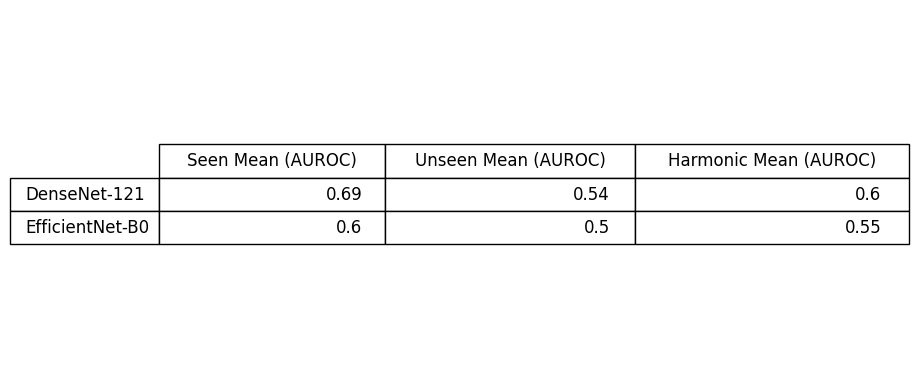

In [17]:
df = pd.DataFrame(results).T.round(2)

fig, ax = plt.subplots()
ax.axis('off')

tbl = table(ax, df, loc='center', colWidths=[ 0.02 * (len(col)+2) for col in df.columns.tolist() ])
tbl.auto_set_font_size(False)
tbl.set_fontsize(12)
tbl.scale(1.2, 2)

plt.show()